#### * Step 1: Package import and mode save path

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBRegressor, XGBClassifier
import joblib
import warnings
warnings.filterwarnings("ignore")


In [4]:
import os
MODEL_DIR = "./forecast_model"
os.makedirs(MODEL_DIR, exist_ok=True)

#### * Step 2:Loading Data

In [6]:
# Load your CSV data
df = pd.read_csv("data-1752622446597.csv")

# Preview
df.head()


site_code                   site_name         site_type   latitude  \
0       BP0  Westminster - Bridge Place  Urban Background  51.493851   
1       BP0  Westminster - Bridge Place  Urban Background  51.493851   
2       BP0  Westminster - Bridge Place  Urban Background  51.493851   
3       BP0  Westminster - Bridge Place  Urban Background  51.493851   
4       BP0  Westminster - Bridge Place  Urban Background  51.493851   

   longitude             datetime  day_of_week  aqi      co    no  ...  \
0  -0.143808  2024-07-13 05:00:00            6    1  166.89  0.02  ...   
1  -0.143808  2024-07-13 06:00:00            6    1  171.90  0.35  ...   
2  -0.143808  2024-07-13 07:00:00            6    1  173.57  0.88  ...   
3  -0.143808  2024-07-13 08:00:00            6    1  173.57  2.15  ...   
4  -0.143808  2024-07-13 09:00:00            6    1  171.90  3.16  ...   

   dew_point  uvi  clouds  visibility  wind_speed  wind_deg  weather_main  \
0     282.58  NaN     100     10000.0        2.57       290        Clouds   
1     283.18  NaN      40     10000.0        2.57       270        Clouds   
2     283.50  NaN     100     10000.0        4.63       260        Clouds   
3     283.66  NaN      75     10000.0        4.63       300          Rain   
4     283.65  NaN      75     10000.0        3.60       290        Clouds   

   weather_description  traffic_flow  traffic_density  
0      overcast clouds      moderate         moderate  
1     scattered clouds      moderate         moderate  
2      overcast clouds      moderate         moderate  
3           light rain      moderate         moderate  
4        broken clouds      moderate         moderate  

[5 rows x 30 columns]

#### * Step 3: Data Cleaning and Sorting based on dates

In [8]:
# Convert datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Map textual traffic columns to ordinal integers
traffic_map = {'low': 0, 'moderate': 1, 'high': 2}
df['traffic_flow'] = df['traffic_flow'].map(traffic_map)
df['traffic_density'] = df['traffic_density'].map(traffic_map)

# Sort by datetime and then site_code
df = df.sort_values(by=['datetime', 'site_code']).reset_index(drop=True)

# Check
df[['datetime', 'site_code', 'traffic_flow', 'traffic_density']].head()


datetime site_code  traffic_flow  traffic_density
0 2024-07-11 00:00:00       VS1             0                2
1 2024-07-11 01:00:00       VS1             0                2
2 2024-07-11 02:00:00       VS1             0                2
3 2024-07-11 03:00:00       VS1             0                2
4 2024-07-11 04:00:00       VS1             0                2

#### * Step 4: Exploratory Data Analysis (EDA)

site_code                   0
site_name                   0
site_type                   0
latitude                    0
longitude                   0
datetime                    0
day_of_week                 0
aqi                         0
co                          0
no                          0
no2                         0
o3                          0
so2                         0
pm2_5                       0
pm10                        0
nh3                         0
temp                        0
feels_like                  0
pressure                    0
humidity                    0
dew_point                   0
uvi                    174519
clouds                      0
visibility              16925
wind_speed                  0
wind_deg                    0
weather_main                0
weather_description         0
traffic_flow                0
traffic_density             0
dtype: int64
site_code              0
site_name              0
site_type              0
latitude    

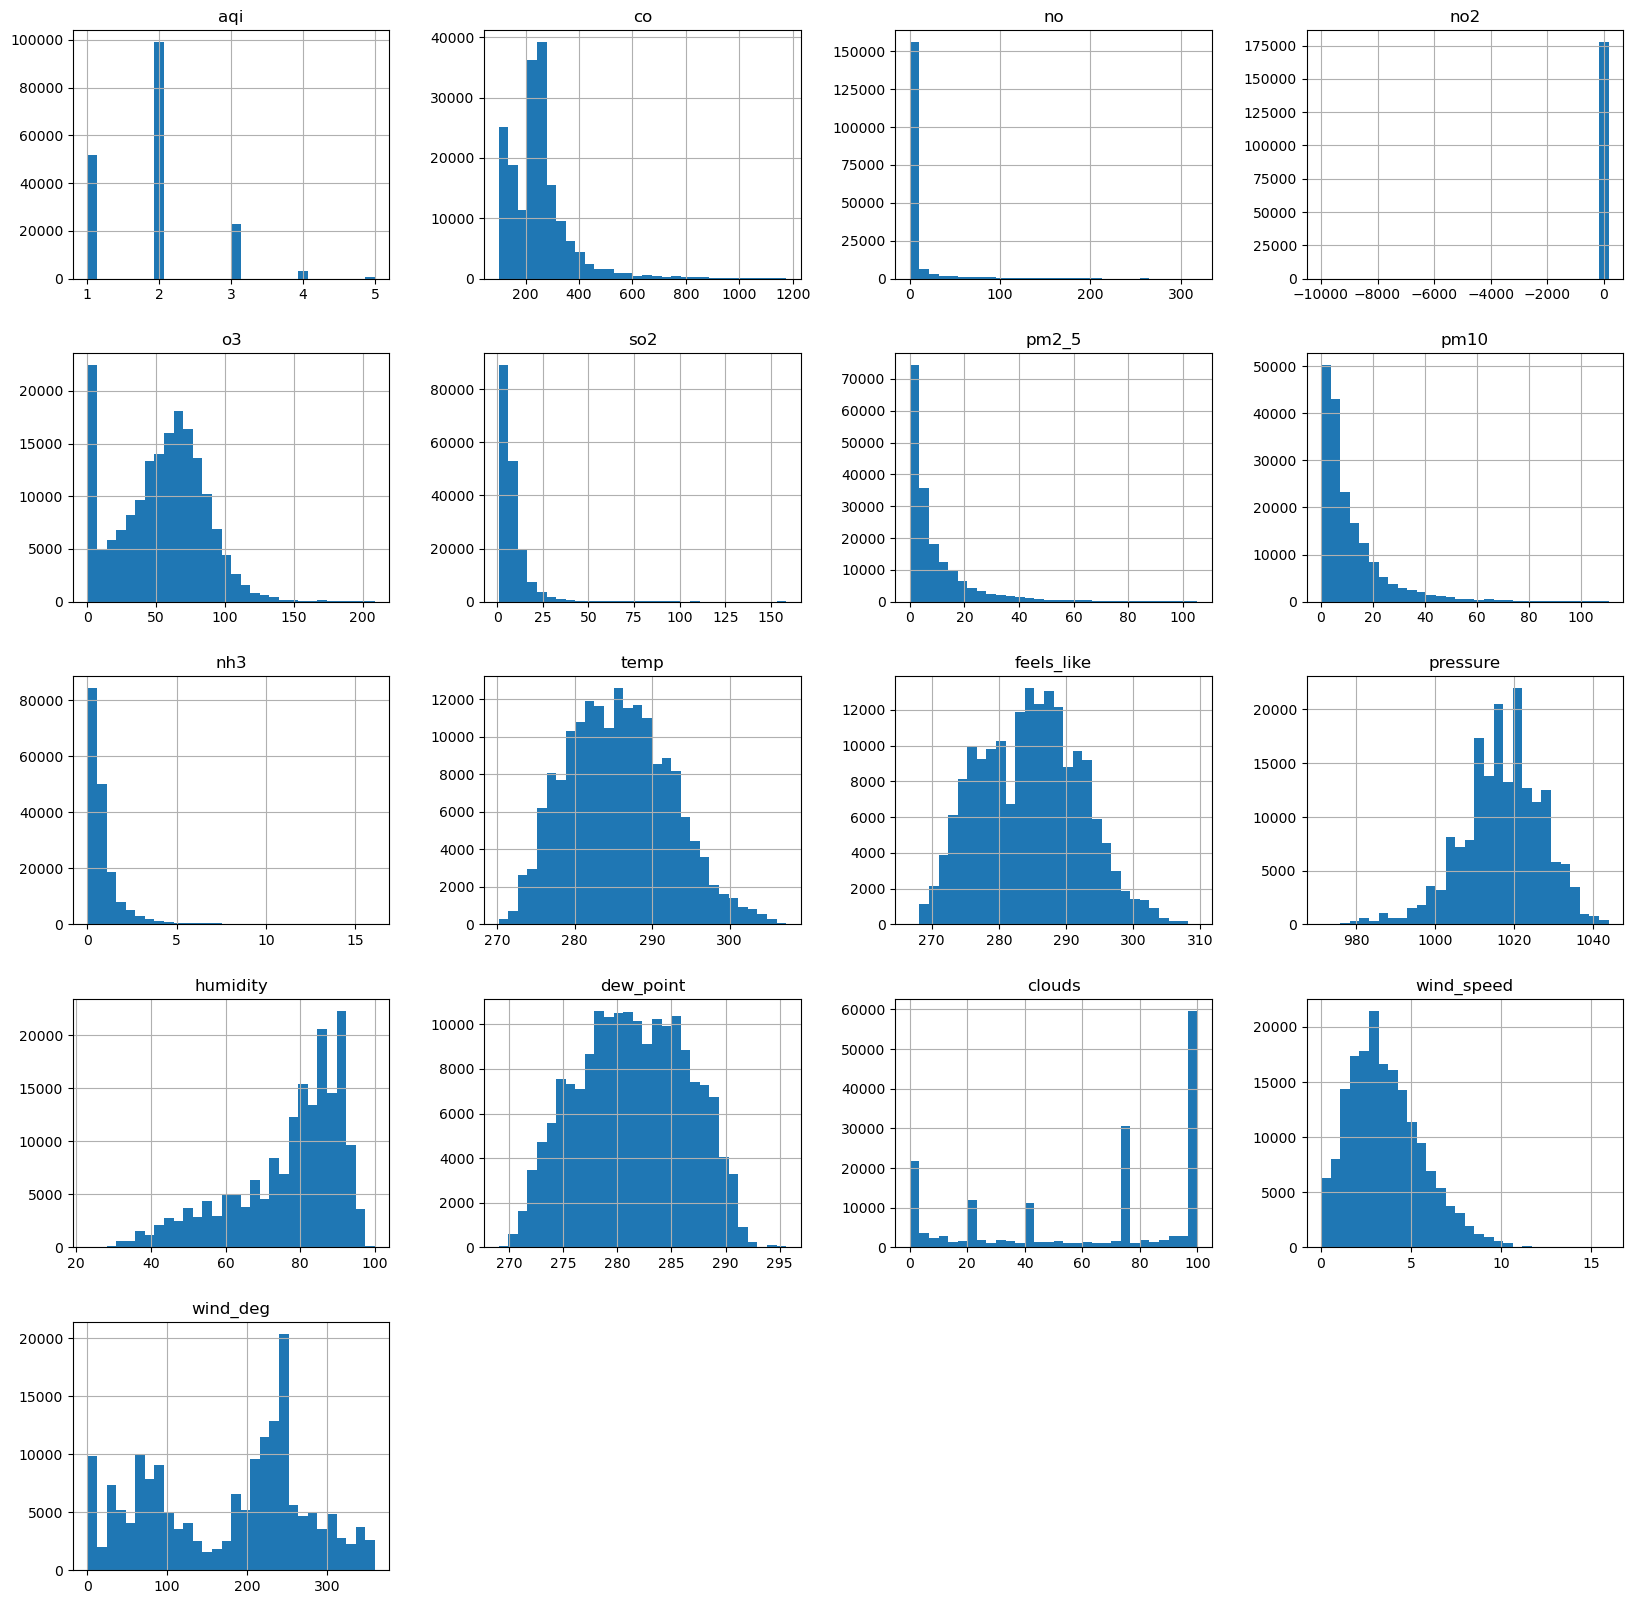

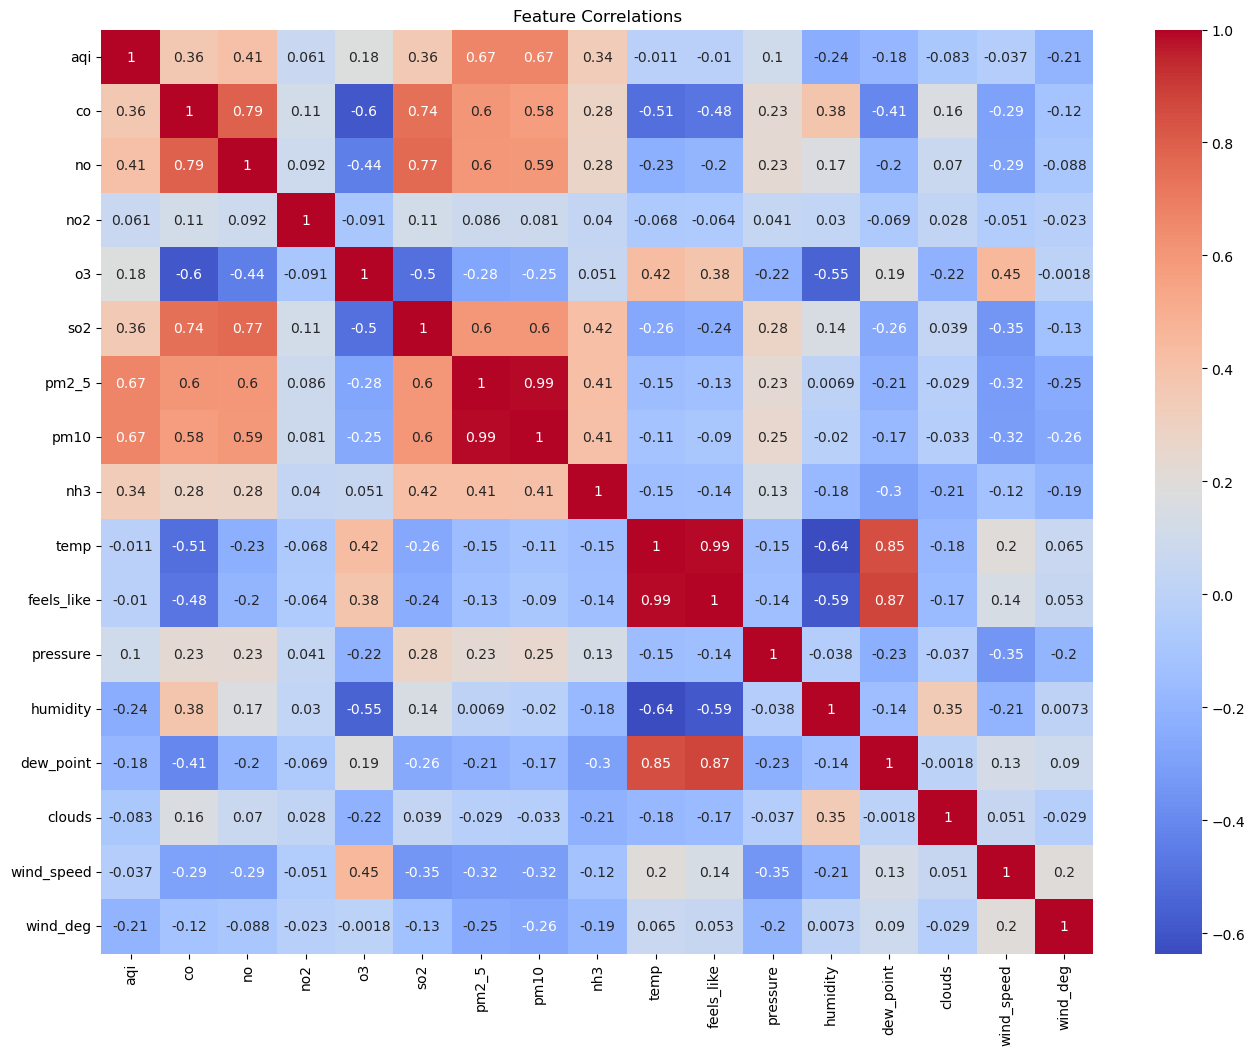

In [10]:
# Missing values
print(df.isnull().sum())

# Drop columns with most nulls
df = df.drop(['visibility', 'uvi'], axis=1)

#check null removed
# Missing values
print(df.isnull().sum())

# Numeric columns for analysis
numeric_cols = ['aqi', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3', 
                'temp', 'feels_like', 'pressure', 'humidity', 'dew_point', 
                'clouds', 'wind_speed', 'wind_deg']

# Histograms
df[numeric_cols].hist(figsize=(20, 20), bins=30)
plt.show()

# Correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlations")
plt.show()


#### * Step 5: Encode Categorical Columns

In [12]:
# Encode site_code and site_type
le_site = LabelEncoder()
df['site_code_enc'] = le_site.fit_transform(df['site_code'])

le_type = LabelEncoder()
df['site_type_enc'] = le_type.fit_transform(df['site_type'])

#### Step 6: Feature Engineering

In [14]:
# Temporal features
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['weekday'] = df['datetime'].dt.weekday

#### Step 7: Define Features and Targets

In [16]:
# Features: only site_code, latitude, longitude, datetime-derived features
features = ['site_code_enc', 'latitude', 'longitude', 'hour', 'day', 'month', 'weekday']

# Regression targets
regression_targets = numeric_cols

# Classification targets (ordinal)
classification_targets = ['traffic_flow', 'traffic_density']


#### Step 8: Split Data into training and test

In [18]:
# Features
X = df[features]

# Regression labels
y_reg = df[regression_targets]

# Classification labels
y_class = df[classification_targets]

# Train-test split (time-based, no shuffle)
X_train, X_test, y_reg_train, y_reg_test, y_class_train, y_class_test = train_test_split(
    X, y_reg, y_class, test_size=0.2, shuffle=True
)

print("Traffic flow train classes:", np.unique(y_class_train['traffic_flow']))
print("Traffic density train classes:", np.unique(y_class_train['traffic_density']))

Traffic flow train classes: [0 1 2]
Traffic density train classes: [0 1 2]


#### Step 9: Feature Scaling

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
scaler_path = os.path.join(MODEL_DIR, "scaler.joblib")
joblib.dump(scaler, scaler_path)
print(f"✅ Saved scaler: {scaler_path}")

✅ Saved scaler: ./forecast_model\scaler.joblib


#### Step 10: Encode classification targets

In [22]:
label_encoders = {}

for col in classification_targets:
    le = LabelEncoder()
    le.fit(df[col])  # Use full original column to capture all possible classes
    y_class_train[col] = le.transform(y_class_train[col])
    y_class_test[col] = le.transform(y_class_test[col])
    label_encoders[col] = le

#### Step 11: Regression Modeling train and predict with performance plots

✅ Saved model: ./forecast_model\model_regression_aqi.json
=== aqi ===
RMSE: 0.39355146576027317
MAE: 0.3018913101792913
R2: 0.7064566064546837



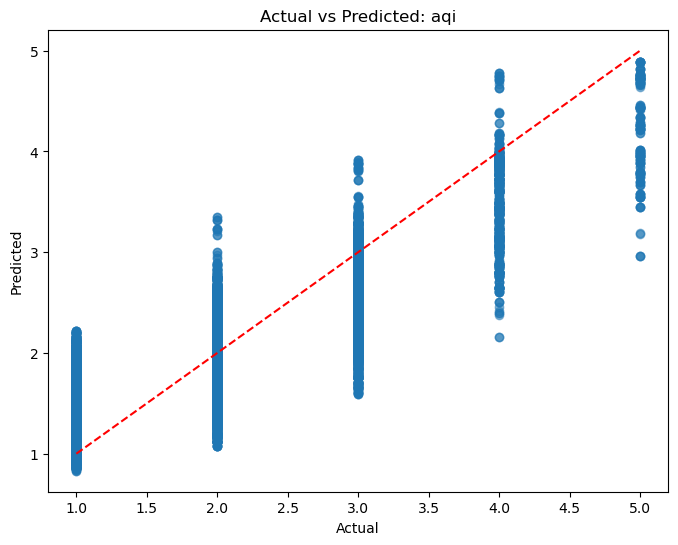

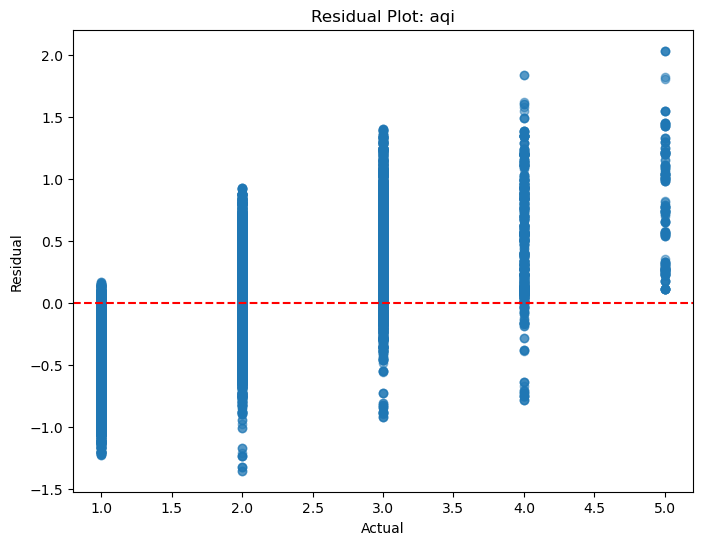

✅ Saved model: ./forecast_model\model_regression_co.json
=== co ===
RMSE: 38.200439446437095
MAE: 20.856575780421167
R2: 0.8982552148617992



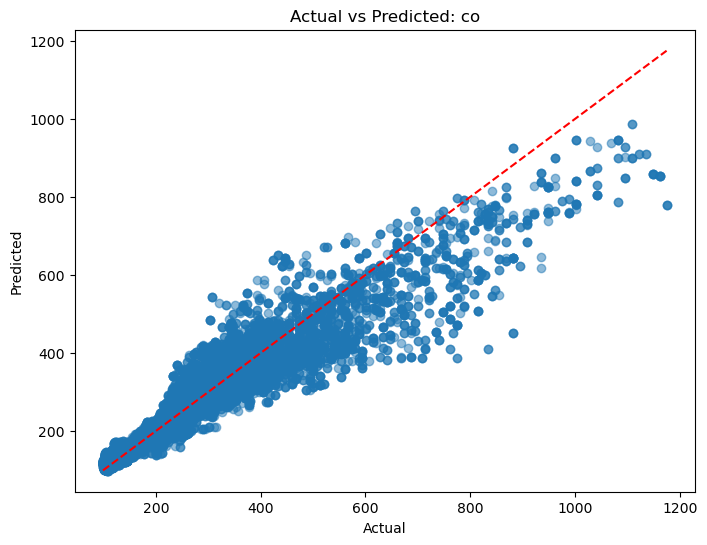

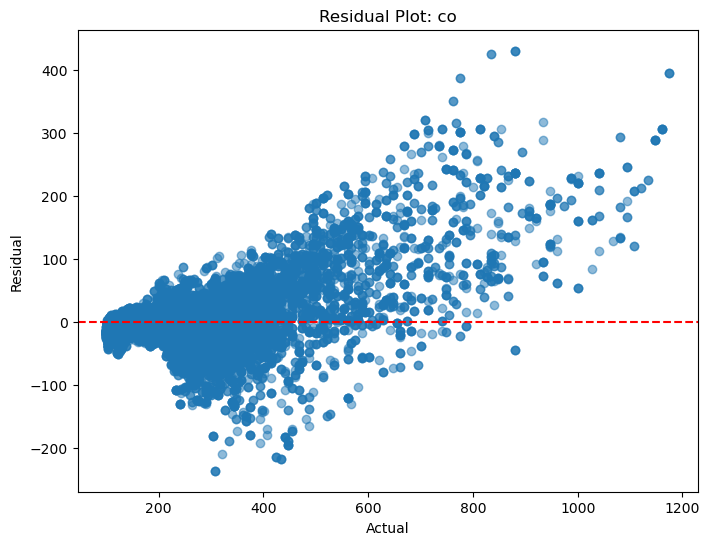

✅ Saved model: ./forecast_model\model_regression_no.json
=== no ===
RMSE: 11.93674615795128
MAE: 5.369807188246513
R2: 0.8292646879160647



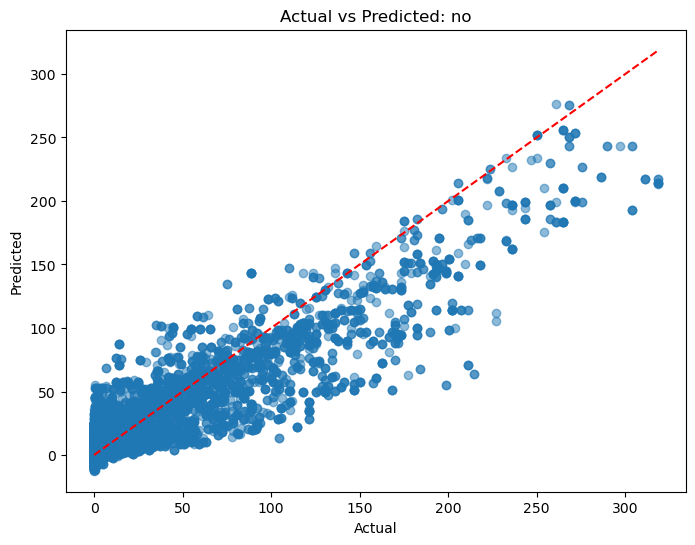

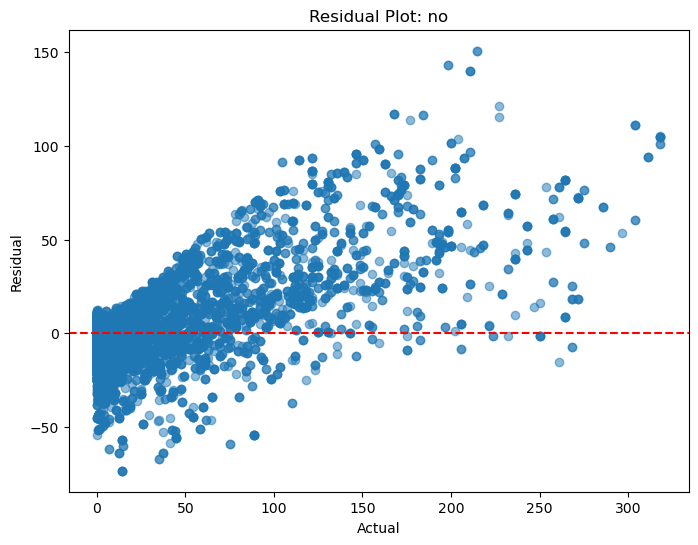

✅ Saved model: ./forecast_model\model_regression_no2.json
=== no2 ===
RMSE: 28.44710026851616
MAE: 8.257286929127014
R2: 0.9687281794895014



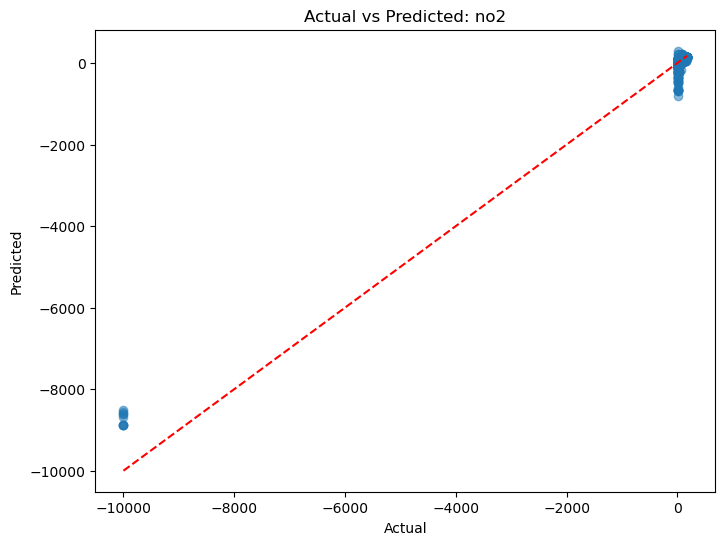

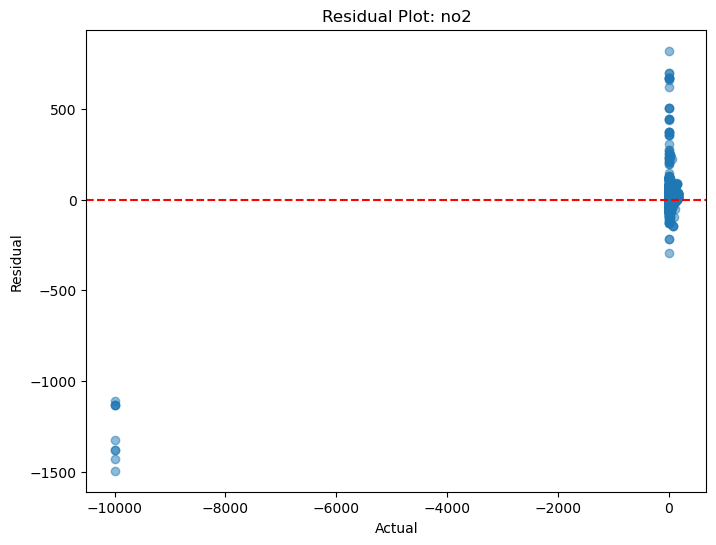

✅ Saved model: ./forecast_model\model_regression_o3.json
=== o3 ===
RMSE: 13.288270815911691
MAE: 10.235262012341325
R2: 0.8211112755669394



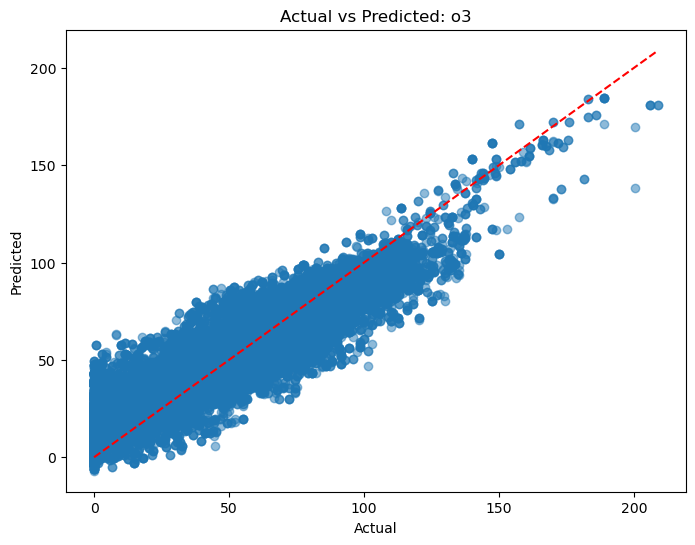

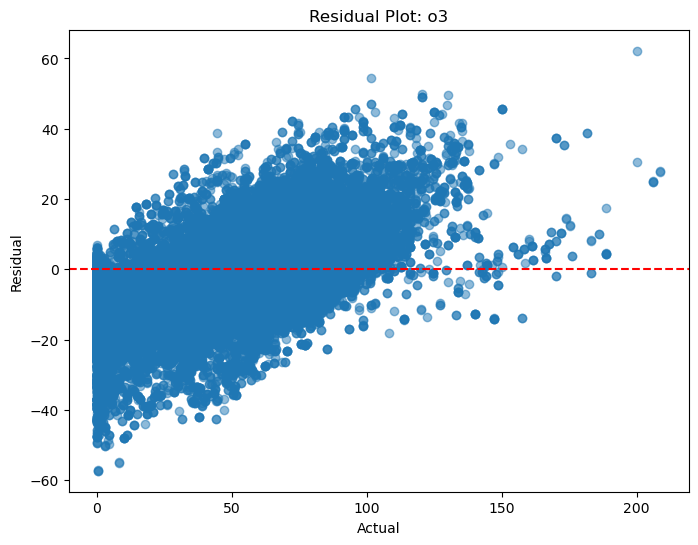

✅ Saved model: ./forecast_model\model_regression_so2.json
=== so2 ===
RMSE: 3.940869855603039
MAE: 2.3475850116577224
R2: 0.8158391209681658



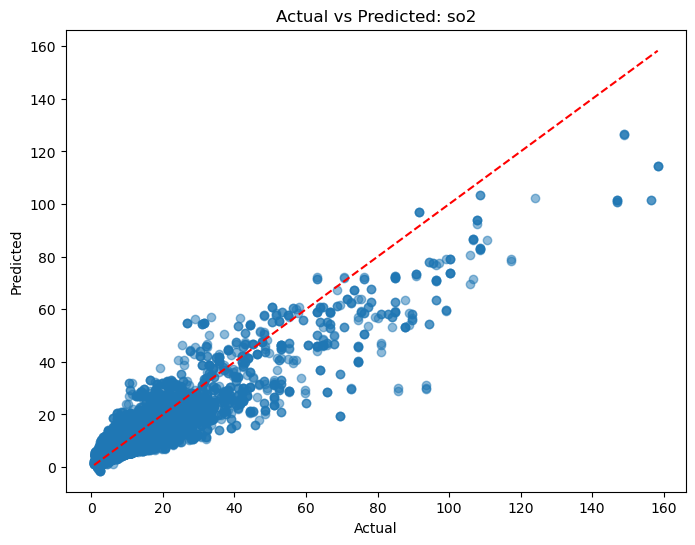

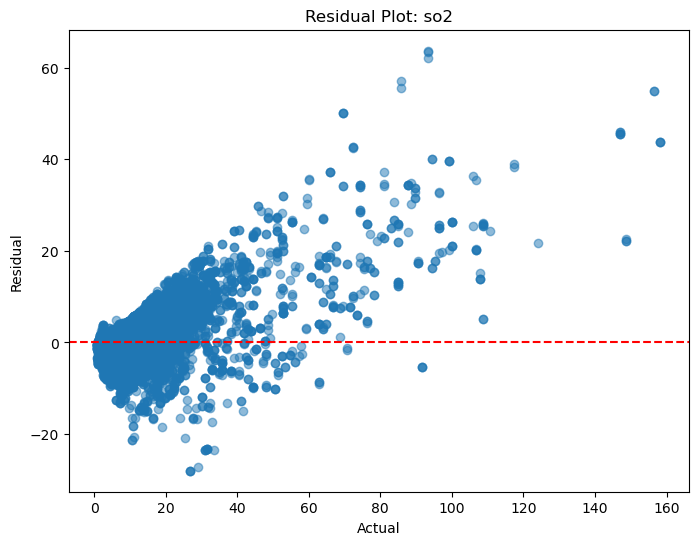

✅ Saved model: ./forecast_model\model_regression_pm2_5.json
=== pm2_5 ===
RMSE: 4.359219822249532
MAE: 2.7864427327581938
R2: 0.881452639040081



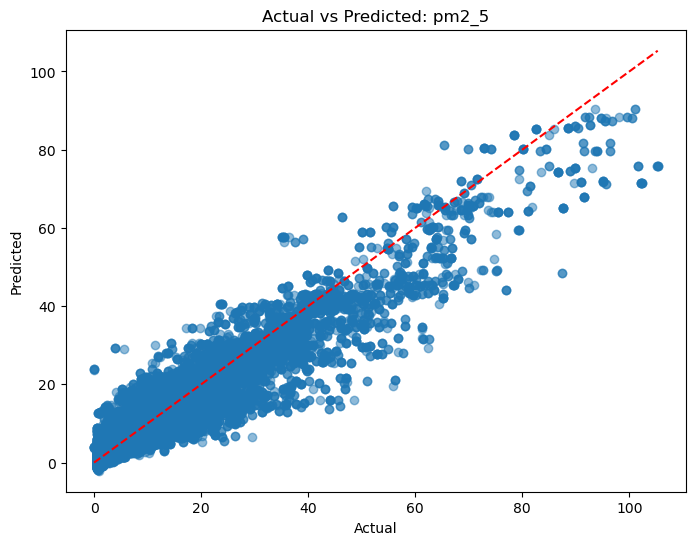

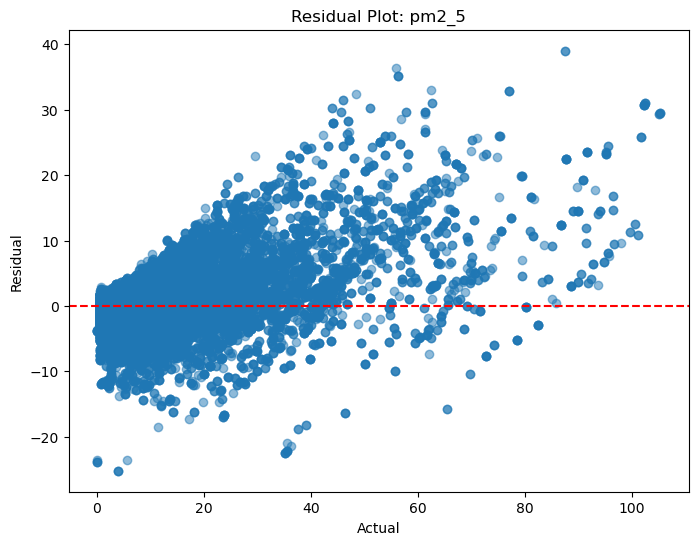

✅ Saved model: ./forecast_model\model_regression_pm10.json
=== pm10 ===
RMSE: 4.586277605290909
MAE: 2.9896918296293298
R2: 0.8794852338854151



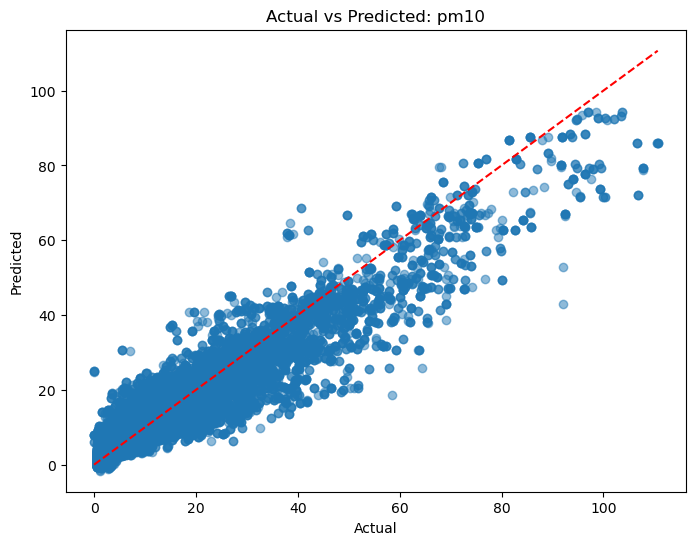

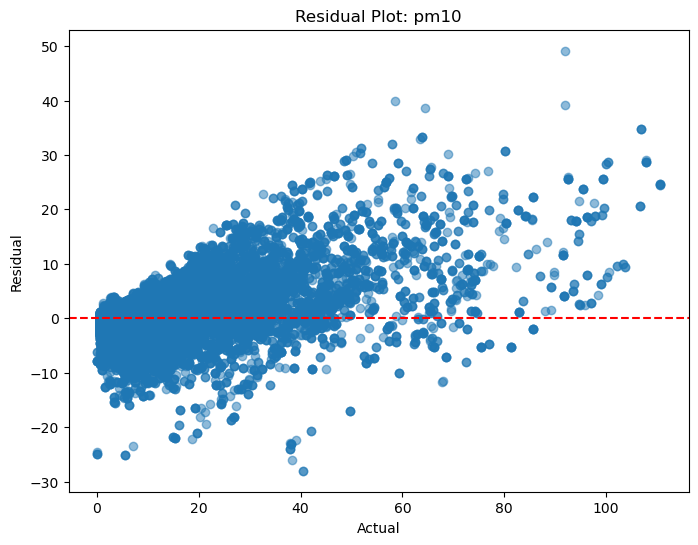

✅ Saved model: ./forecast_model\model_regression_nh3.json
=== nh3 ===
RMSE: 0.5032392914103998
MAE: 0.28943347046850115
R2: 0.8337268017026961



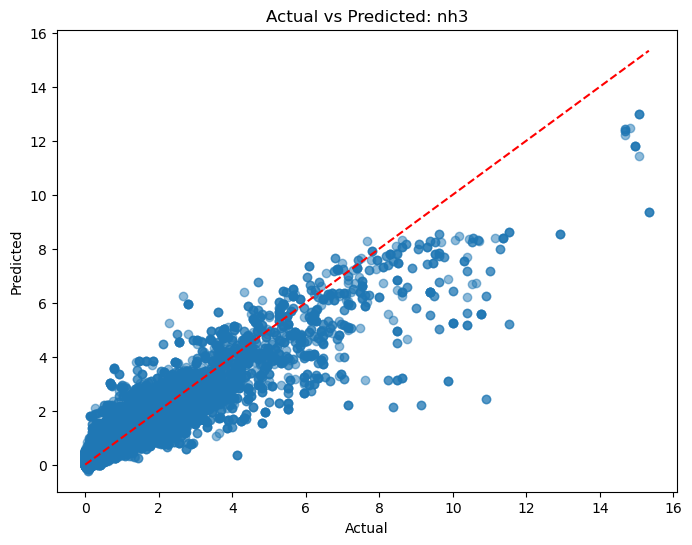

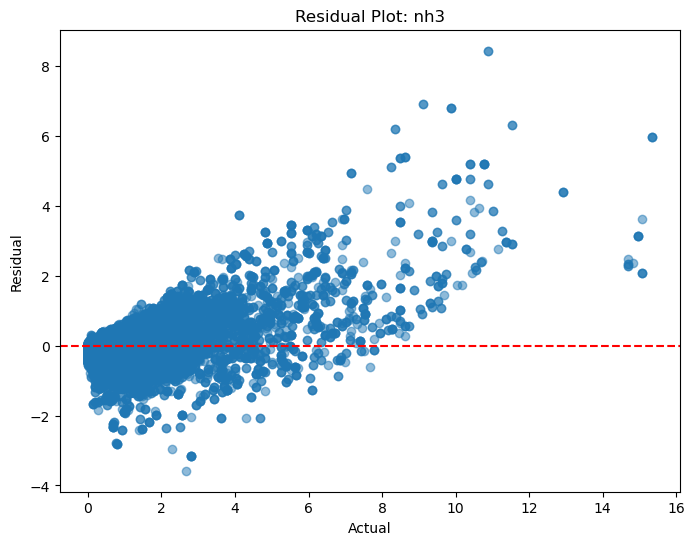

✅ Saved model: ./forecast_model\model_regression_temp.json
=== temp ===
RMSE: 1.2349029144698358
MAE: 0.9410033408243261
R2: 0.9651546984069987



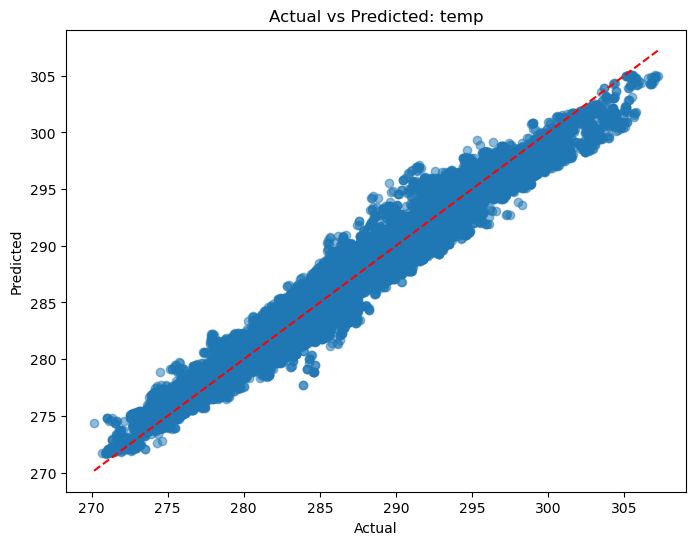

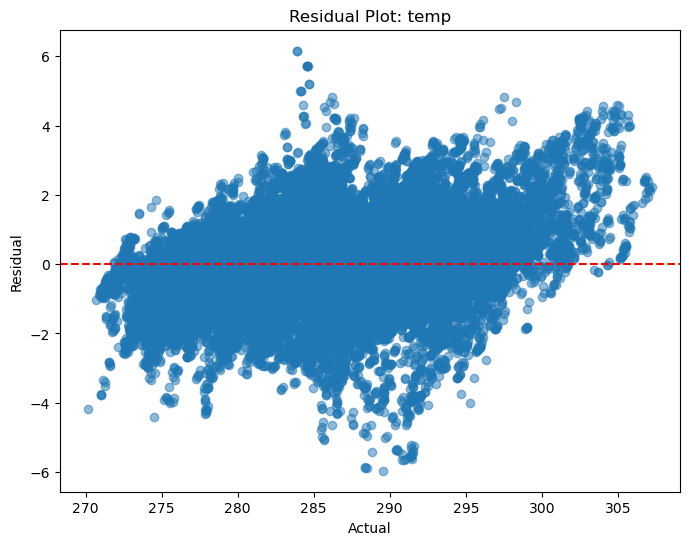

✅ Saved model: ./forecast_model\model_regression_feels_like.json
=== feels_like ===
RMSE: 1.440742378786576
MAE: 1.102876778520881
R2: 0.9630124906112998



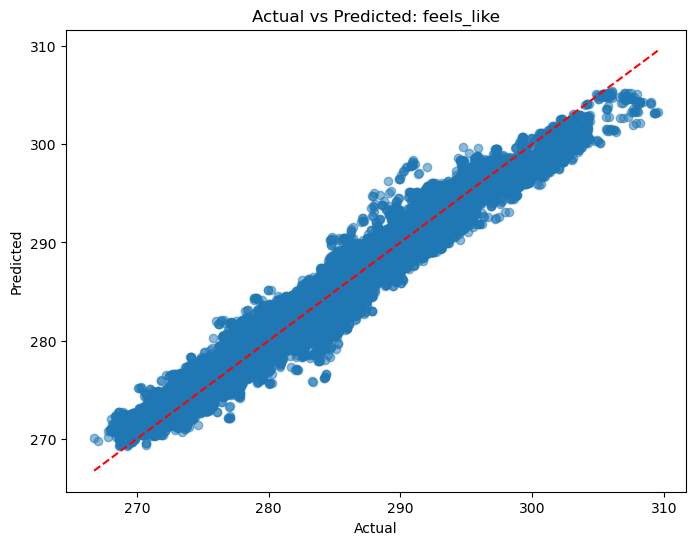

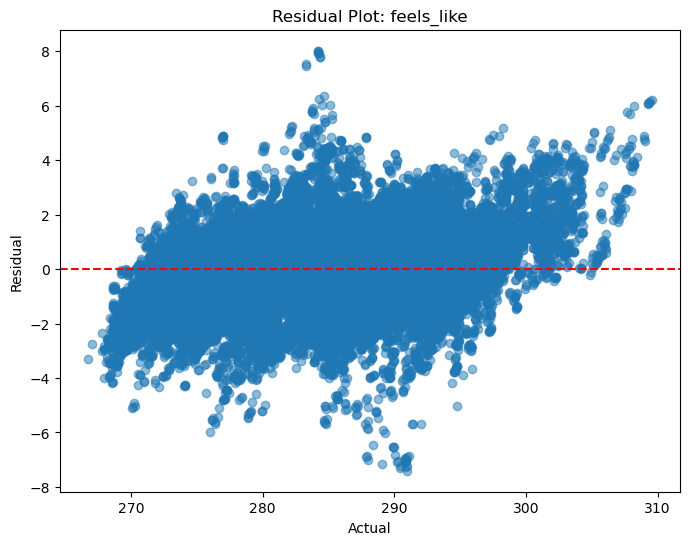

✅ Saved model: ./forecast_model\model_regression_pressure.json
=== pressure ===
RMSE: 2.07223239007551
MAE: 1.549197143376001
R2: 0.9593275212038936



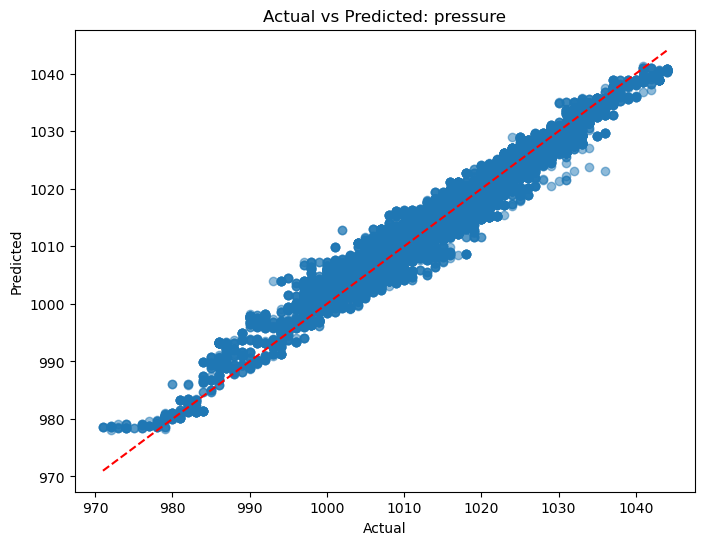

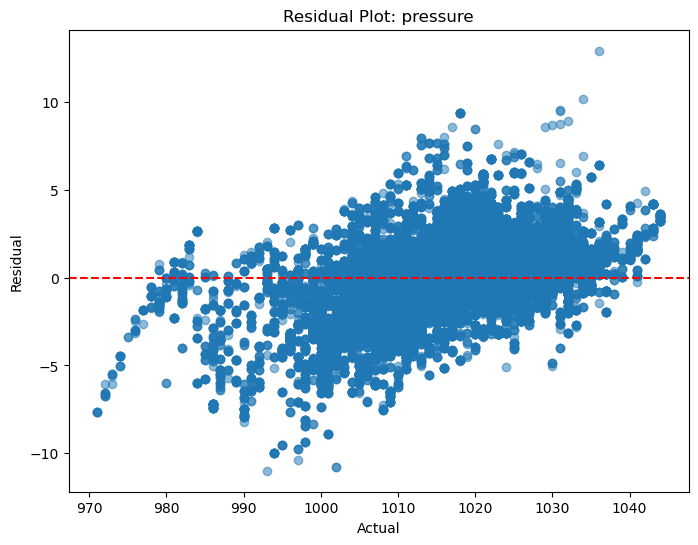

✅ Saved model: ./forecast_model\model_regression_humidity.json
=== humidity ===
RMSE: 5.009513868335224
MAE: 3.6413493546772724
R2: 0.8859073951429697



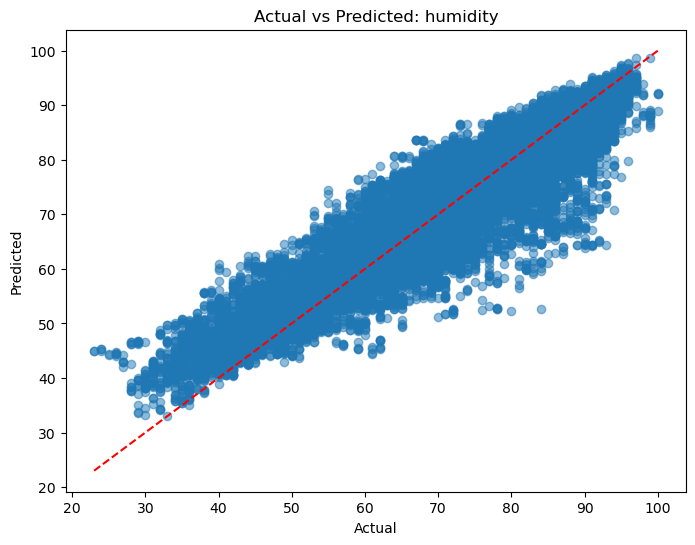

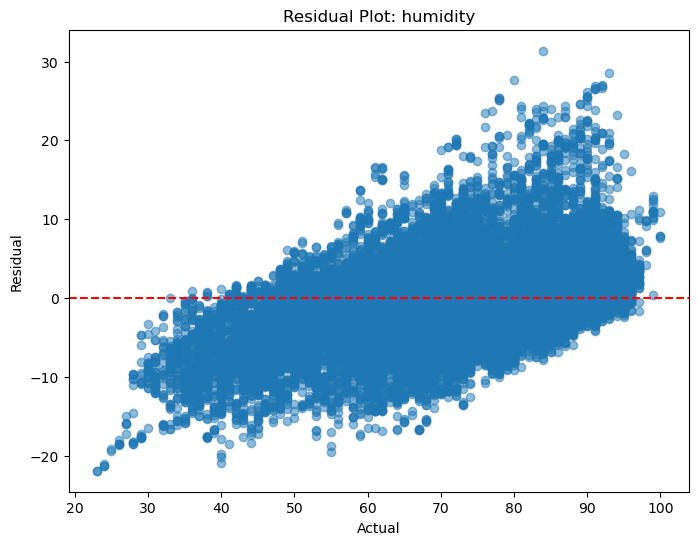

✅ Saved model: ./forecast_model\model_regression_dew_point.json
=== dew_point ===
RMSE: 1.2156079159058892
MAE: 0.9372384494076629
R2: 0.9411293385912008



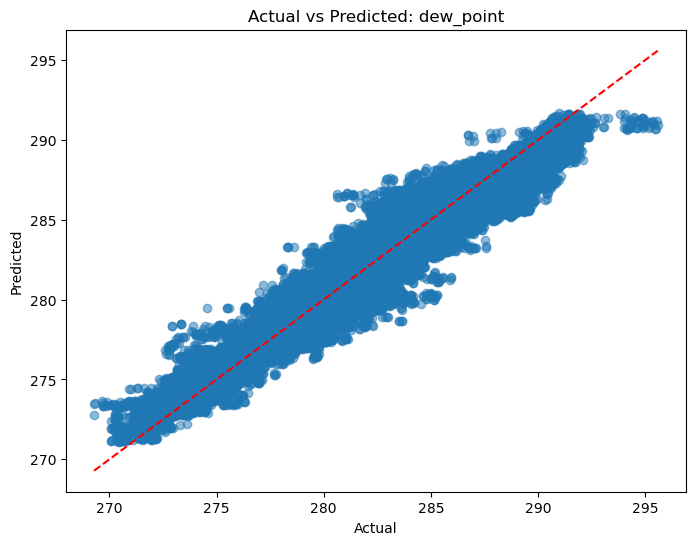

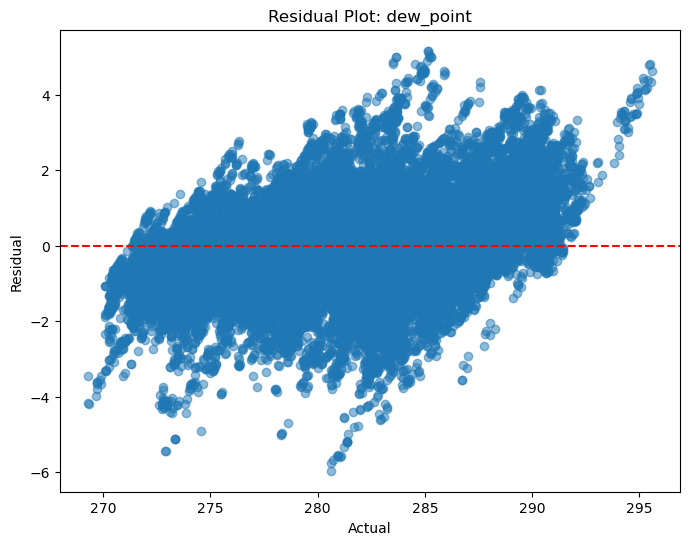

✅ Saved model: ./forecast_model\model_regression_clouds.json
=== clouds ===
RMSE: 25.7566224741039
MAE: 21.08495795837935
R2: 0.5234606647812134



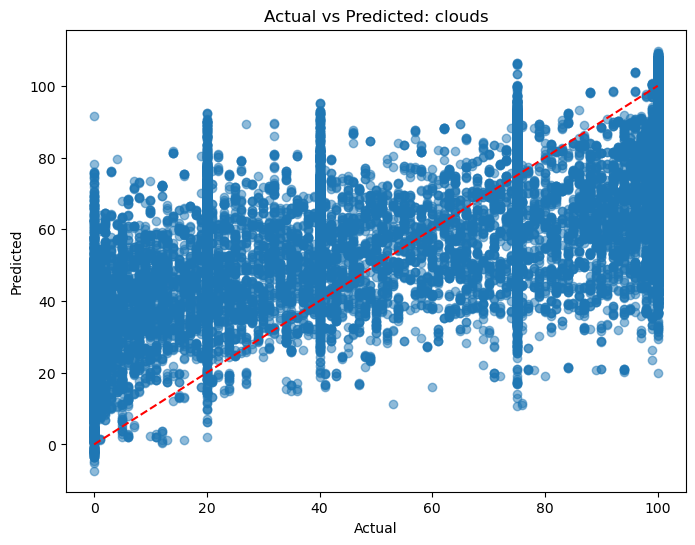

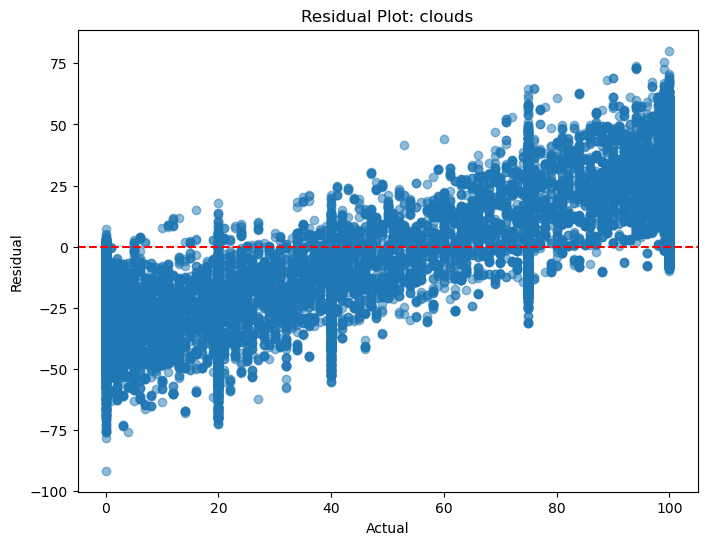

✅ Saved model: ./forecast_model\model_regression_wind_speed.json
=== wind_speed ===
RMSE: 1.1106014841363818
MAE: 0.8564444386122155
R2: 0.6842292837752408



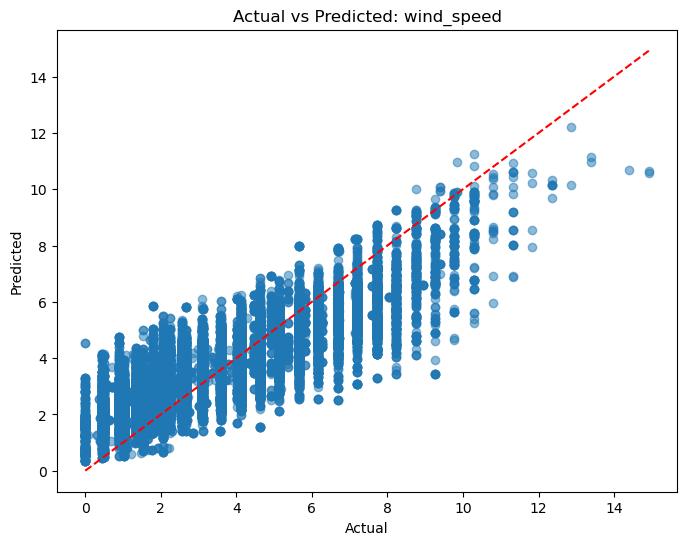

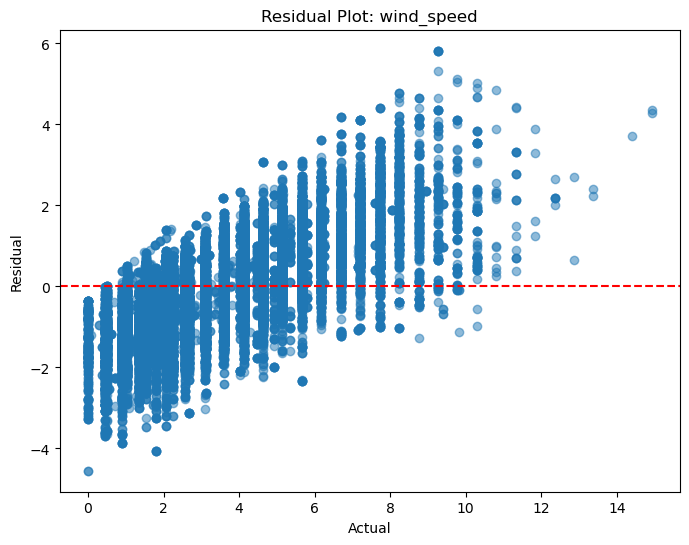

✅ Saved model: ./forecast_model\model_regression_wind_deg.json
=== wind_deg ===
RMSE: 63.19869646088643
MAE: 42.42357216143364
R2: 0.5847762734286871



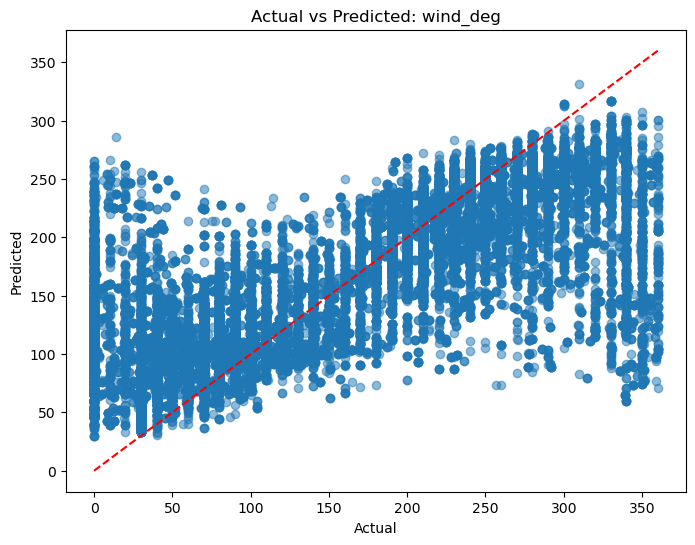

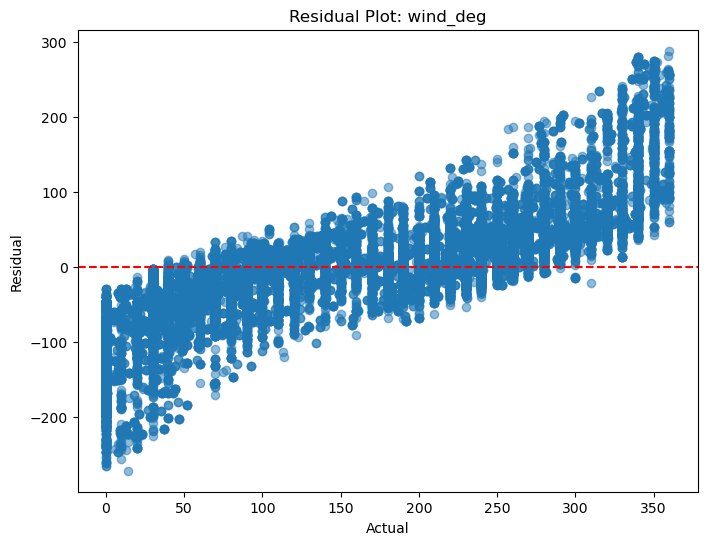

In [24]:
regression_preds = pd.DataFrame(index=y_reg_test.index)
regression_models = {}

for col in regression_targets:
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train_scaled, y_reg_train[col])
    model_path = os.path.join(MODEL_DIR, f"model_regression_{col}.json")
    model.save_model(model_path)
    print(f"✅ Saved model: {model_path}")
    y_pred = model.predict(X_test_scaled)
    regression_preds[col] = y_pred
    regression_models[col] = model

    print(f"=== {col} ===")
    print("RMSE:", np.sqrt(mean_squared_error(y_reg_test[col], y_pred)))
    print("MAE:", mean_absolute_error(y_reg_test[col], y_pred))
    print("R2:", r2_score(y_reg_test[col], y_pred))
    print()
    # --- Actual vs Predicted Plot ---
    plt.figure(figsize=(8, 6))
    plt.scatter(y_reg_test[col], regression_preds[col], alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted: {col}")
    plt.plot(
        [y_reg_test[col].min(), y_reg_test[col].max()],
        [y_reg_test[col].min(), y_reg_test[col].max()],
        'r--'
    )
    plt.show()
    # --- Residual Plot ---
    residuals = y_reg_test[col] - regression_preds[col]
    plt.figure(figsize=(8, 6))
    plt.scatter(y_reg_test[col], residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Actual")
    plt.ylabel("Residual")
    plt.title(f"Residual Plot: {col}")
    plt.show()

#### Step 12: Classification Modeling train and test with plots

✅ Saved model: ./forecast_model\model_classification_traffic_flow.json
=== traffic_flow ===
Accuracy: 0.9994088503546897

✅ Saved model: ./forecast_model\model_classification_traffic_density.json
=== traffic_density ===
Accuracy: 0.9994088503546897



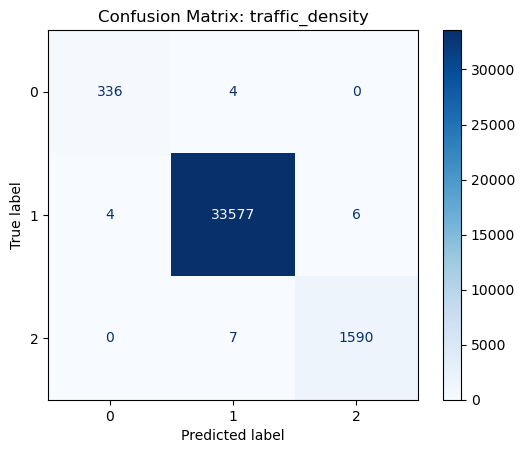

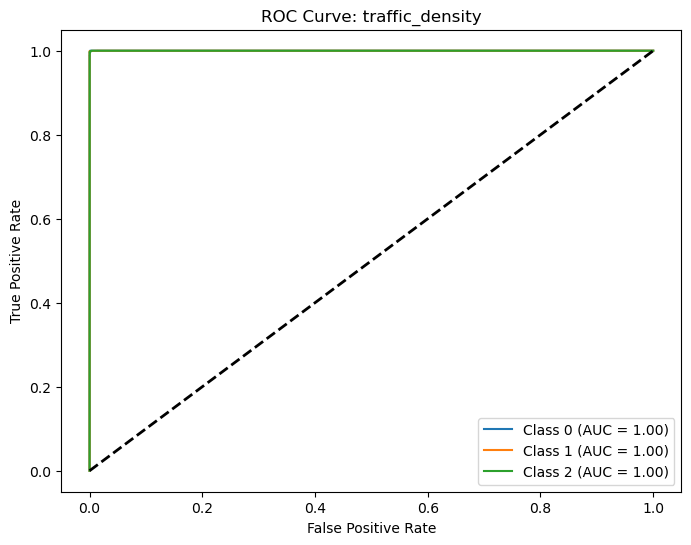

In [26]:
classification_preds = pd.DataFrame(index=y_class_test.index)
classification_models = {}

for col in classification_targets:
    num_classes = len(np.unique(y_class_train[col]))
    model = XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42)
    model.fit(X_train_scaled, y_class_train[col])
    model_path = os.path.join(MODEL_DIR, f"model_classification_{col}.json")
    model.save_model(model_path)
    print(f"✅ Saved model: {model_path}")
    y_pred = model.predict(X_test_scaled)
    classification_preds[col] = y_pred
    classification_models[col] = model

    acc = accuracy_score(y_class_test[col], y_pred)
    print(f"=== {col} ===")
    print("Accuracy:", acc)
    print()

# Confusion matrix
cm = confusion_matrix(y_class_test[col], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix: {col}")
plt.show()

# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_class_test[col], classes=[0, 1, 2])
y_score = model.predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_class_test[col]))):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y_class_test[col]))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve: {col}")
plt.legend(loc="lower right")
plt.show()